Fitbit data for one individual.  Looks like a he/she left it off from time to time.  Assuming sleep and work for monday through friday, 2/3 of the day is sedentary.  

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import itertools
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire

In [2]:
# df1 = pd.read_csv('2018-04-26_and_2018-05-26.csv', nrows=31)
# df2 = pd.read_csv('2018-05-27_and_2018-06-26.csv', nrows=31)
# df3 = pd.read_csv('2018-06-27_and_2018-07-27.csv', nrows=31)
# df4 = pd.read_csv('2018-07-28_and_2018-08-26.csv', nrows=30)
# df5 = pd.read_csv('2018-08-27_and_2018-09-26.csv', nrows=31)
# df6 = pd.read_csv('2018-09-27_and_2018-10-27.csv', nrows=31)
# df7 = pd.read_csv('2018-10-28_and-2018-11-27.csv', nrows=31)
# df8 = pd.read_csv('2018-11-28_and_2018-12-28.csv', nrows=9)

In [3]:
# df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], join="inner", ignore_index=True)

I put above data into my acquire_fitbit_data function

In [4]:
df = acquire.get_fitbit_data()

In [5]:
df.head(1)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566


Rename columns to make them easier to use

In [6]:
df = df.rename(columns = {'Date':'date', 'Calories Burned':'calories_burned', 'Steps':'steps', 'Distance':'distance', 'Floors':'floors', 'Minutes Sedentary':'minutes_sedentary', 'Minutes Lightly Active':'minutes_lightly_active', 'Minutes Fairly Active':'minutes_fairly_active', 'Minutes Very Active':'minutes_very_active', 'Activity Calories':'activity_calories'})
df.head(1)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566


Check to see if there are any nulls

Percent of the day the fitbit was not worn.  Muy importante

In [7]:
# df['percent_not_worn'] = ((1440 - (df.minutes_fairly_active + df.minutes_lightly_active + df.minutes_sedentary + df.minutes_very_active))/1440)*100

In [8]:
# df['bmr'] = df.calories_burned - df.activity_calories

In [9]:
# df['fairly_active_percentage'] = (df.minutes_fairly_active/1440)*100
# df['sedentary_percentage'] = (df.minutes_sedentary/1440)*100
# # df['lightly_active_percentage'] = (df.minutes_lightly_active/1440)*100
# df['very_active_percentage'] = (df.minutes_very_active/1440)*100

In [10]:
# df['gait'] =(df.distance * 5280)/df.steps

In [11]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [12]:
df.isna().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

I had nulls at first and used the below code to fix them, but realized my nulls were due to importing an extra row that didn't exist in the 4th csv

In [13]:
# null_columns=df.columns[df.isnull().any()]
# print(df[df.isnull().any(axis=1)][null_columns].head())

In [14]:
# df.replace(np.nan, 0, inplace=True)

In [15]:
# df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')

Create the to_datetime object

In [16]:
df.date = pd.to_datetime(df.date)

In [17]:
df = df.set_index('date')

In [18]:
df.head(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566


In [19]:
df.dtypes[df.dtypes == 'object']

calories_burned      object
steps                object
minutes_sedentary    object
activity_calories    object
dtype: object

In [20]:
df.calories_burned = df.calories_burned.str.replace(',', '').astype(float)
df.minutes_sedentary = df.minutes_sedentary.astype(str)
df.minutes_sedentary = df.minutes_sedentary.str.replace(',', '').astype(float)
df.activity_calories = df.activity_calories.str.replace(',', '').astype(float)
df.steps = df.steps.str.replace(',', '').astype(float)

In [21]:
df.dtypes

calories_burned           float64
steps                     float64
distance                  float64
floors                      int64
minutes_sedentary         float64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories         float64
dtype: object

In [22]:
df.isnull().sum()

calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

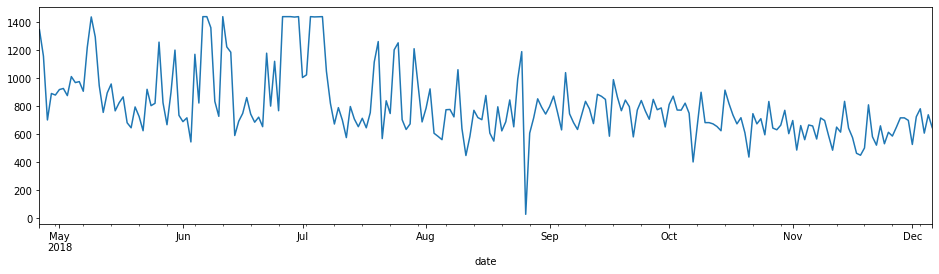

In [23]:
df.minutes_sedentary.resample('D').mean().plot(figsize=(16,4))

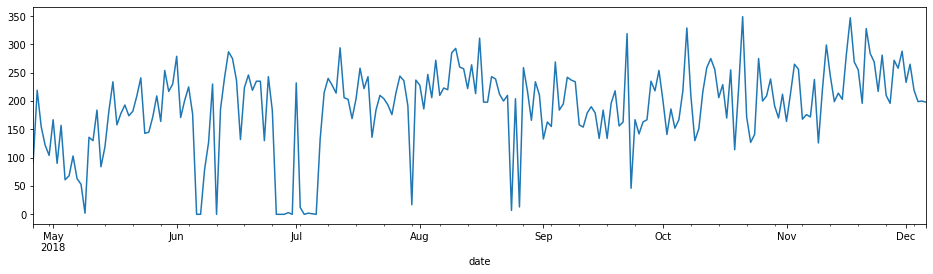

In [24]:
df.minutes_lightly_active.resample('D').mean().plot(figsize=(16,4))

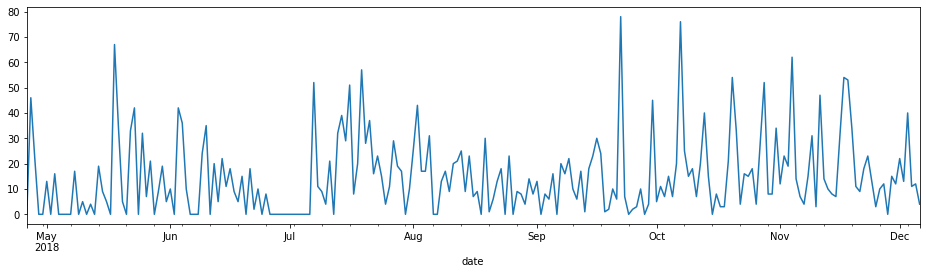

In [25]:
df.minutes_fairly_active.resample('D').mean().plot(figsize=(16,4))

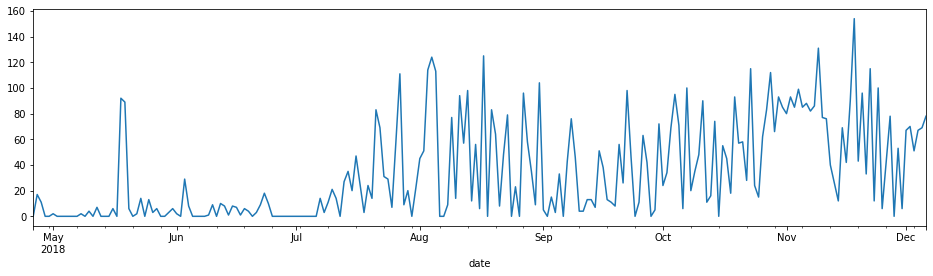

In [26]:
df.minutes_very_active.resample('D').mean().plot(figsize=(16,4))

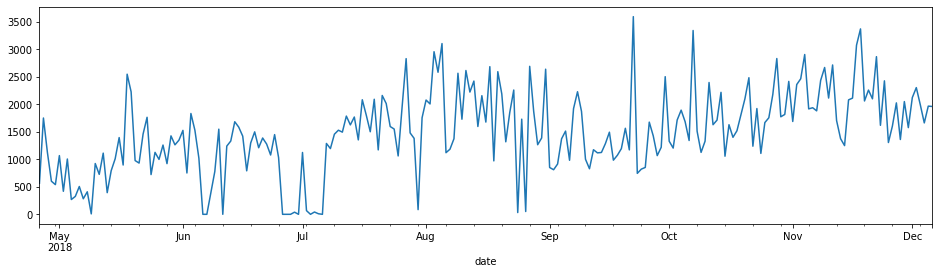

In [27]:
df.activity_calories.resample('D').mean().plot(figsize=(16,4))

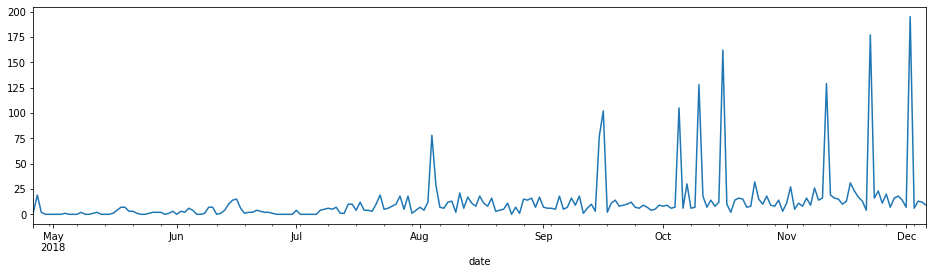

In [28]:
df.floors.resample('D').mean().plot(figsize=(16,4))

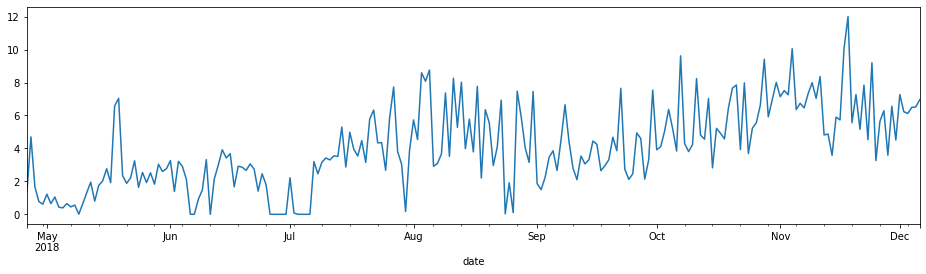

In [29]:
df.distance.resample('D').mean().plot(figsize=(16,4))

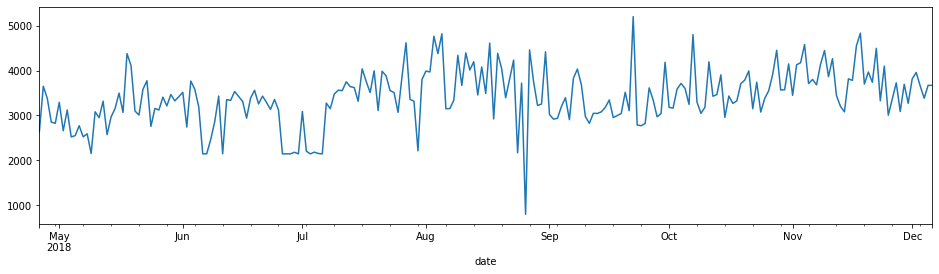

In [30]:
df.calories_burned.resample('D').mean().plot(figsize=(16,4))

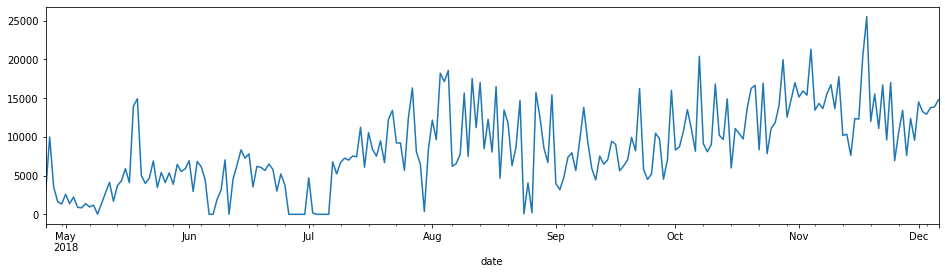

In [31]:
df.steps.resample('D').mean().plot(figsize=(16,4))

In [32]:
df['percent_not_worn'] = ((1440 - (df.minutes_fairly_active + df.minutes_lightly_active + df.minutes_sedentary + df.minutes_very_active))/1440)*100
df['bmr'] = df.calories_burned - df.activity_calories
df['fairly_active_percentage'] = (df.minutes_fairly_active/1440)*100
df['sedentary_percentage'] = (df.minutes_sedentary/1440)*100
df['lightly_active_percentage'] = (df.minutes_lightly_active/1440)*100
df['very_active_percentage'] = (df.minutes_very_active/1440)*100
df['gait'] =(df.distance * 5280)/df.steps




## Quick Model!!!!

In [49]:
df.columns

Index(['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary',
       'minutes_lightly_active', 'minutes_fairly_active',
       'minutes_very_active', 'activity_calories', 'percent_not_worn', 'bmr',
       'fairly_active_percentage', 'sedentary_percentage',
       'lightly_active_percentage', 'very_active_percentage', 'gait'],
      dtype='object')

In [50]:
target_vars=['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary',
       'minutes_lightly_active', 'minutes_fairly_active',
       'minutes_very_active', 'activity_calories']
df = df.resample('D')[target_vars].mean()

In [47]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [48]:
train, test = split_store_data(df, train_prop=.66)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


In [51]:
train = train.set_index('date')
test = test.set_index('date')

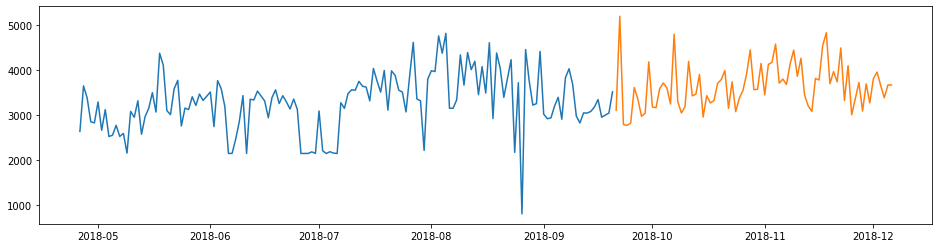

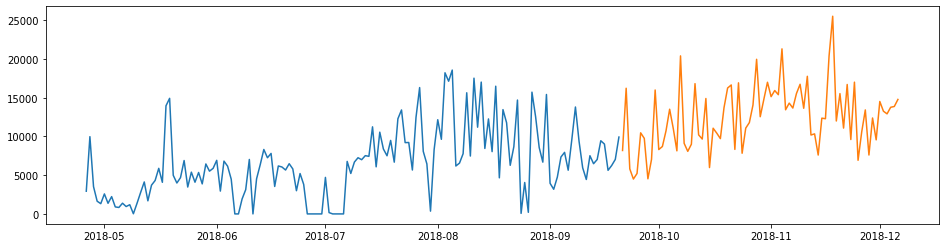

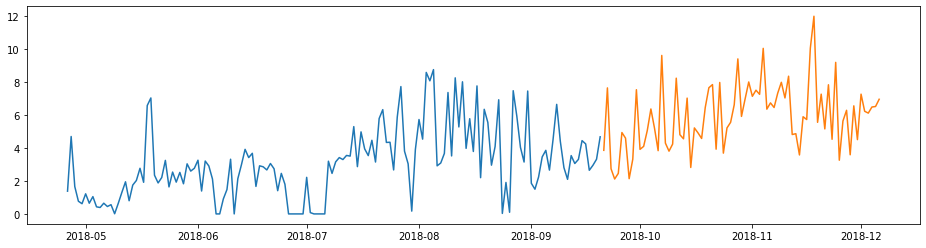

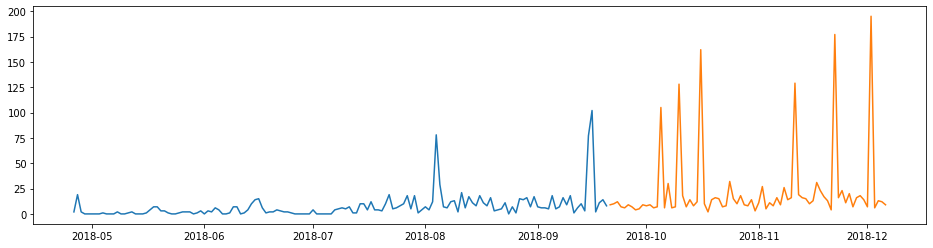

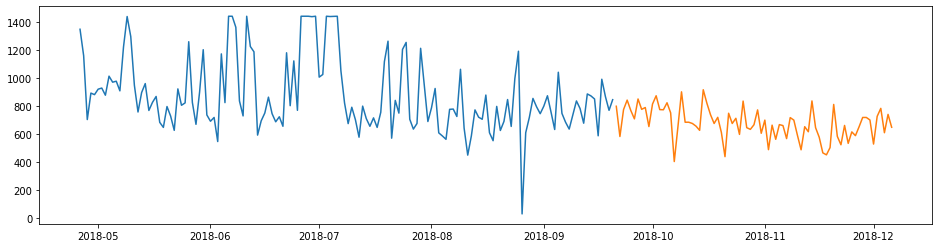

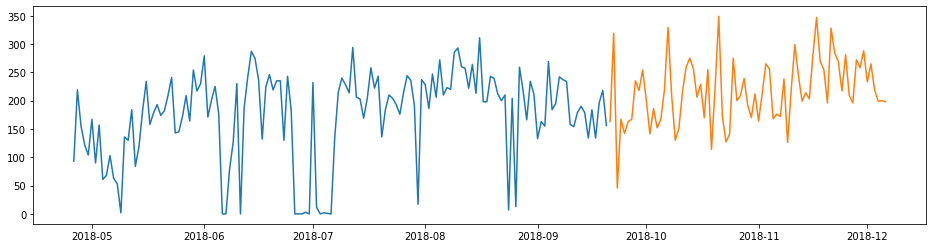

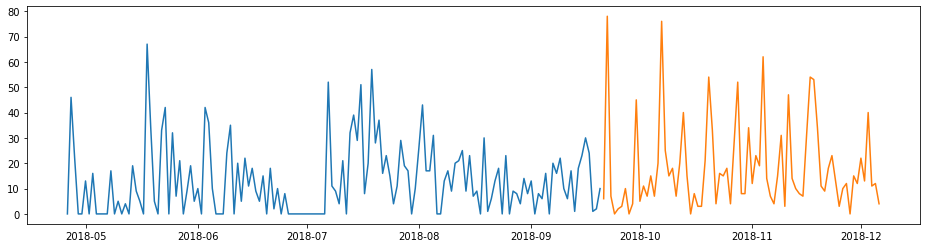

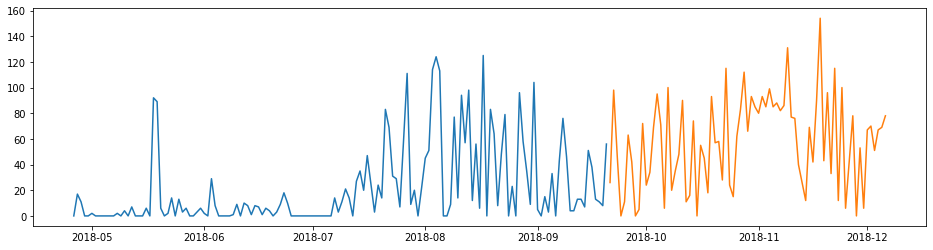

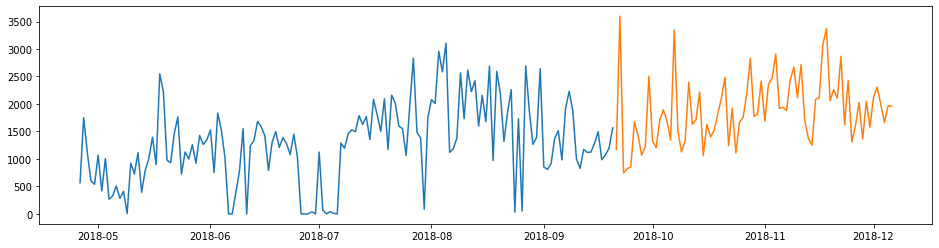

In [54]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [55]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [56]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [57]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [58]:
yhat = pd.DataFrame(test[target_vars])

In [59]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [60]:
yhat.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-09-21,3517,9920,4,8,844,156,10,56,1565
2018-09-22,3517,9920,4,8,844,156,10,56,1565
2018-09-23,3517,9920,4,8,844,156,10,56,1565
2018-09-24,3517,9920,4,8,844,156,10,56,1565
2018-09-25,3517,9920,4,8,844,156,10,56,1565


In [61]:
for var in target_vars:
    print(var, ":", yhat[var].min() == yhat[var].max())

calories_burned : True
steps : True
distance : True
floors : True
minutes_sedentary : True
minutes_lightly_active : True
minutes_fairly_active : True
minutes_very_active : True
activity_calories : True


calories_burned -- MSE: 272763.48 RMSE: 522.27
steps -- MSE: 23685924.27 RMSE: 4866.82
distance -- MSE: 7.74 RMSE: 2.78
floors -- MSE: 1689.47 RMSE: 41.10
minutes_sedentary -- MSE: 40794.61 RMSE: 201.98
minutes_lightly_active -- MSE: 6906.99 RMSE: 83.11
minutes_fairly_active -- MSE: 376.71 RMSE: 19.41
minutes_very_active -- MSE: 1253.71 RMSE: 35.41
activity_calories -- MSE: 466871.45 RMSE: 683.28


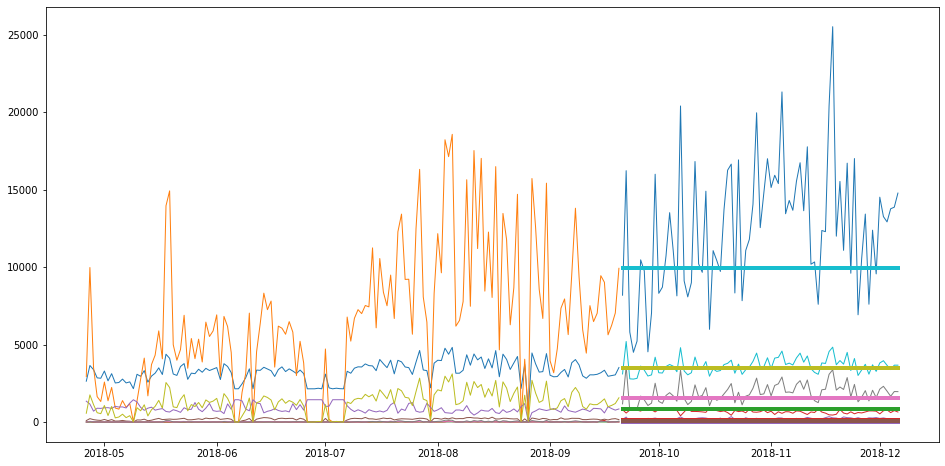

In [66]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

In [67]:
eval_df = append_eval_df(model_type='simple_average', target_vars=target_vars, train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,simple_average,calories_burned,mse,2.727635e+05
1,simple_average,calories_burned,rmse,5.222676e+02
2,simple_average,steps,mse,2.368592e+07
3,simple_average,steps,rmse,4.866819e+03
4,simple_average,distance,mse,7.738770e+00
5,simple_average,distance,rmse,2.781865e+00
6,simple_average,floors,mse,1.689468e+03
7,simple_average,floors,rmse,4.110313e+01
8,simple_average,minutes_sedentary,mse,4.079461e+04
9,simple_average,minutes_sedentary,rmse,2.019768e+02


calories_burned -- MSE: 409202.00 RMSE: 639.69
steps -- MSE: 40032796.13 RMSE: 6327.15
distance -- MSE: 9.24 RMSE: 3.04
floors -- MSE: 1543.40 RMSE: 39.29
minutes_sedentary -- MSE: 22457.01 RMSE: 149.86
minutes_lightly_active -- MSE: 4540.66 RMSE: 67.38
minutes_fairly_active -- MSE: 355.95 RMSE: 18.87
minutes_very_active -- MSE: 2050.60 RMSE: 45.28
activity_calories -- MSE: 631749.91 RMSE: 794.83


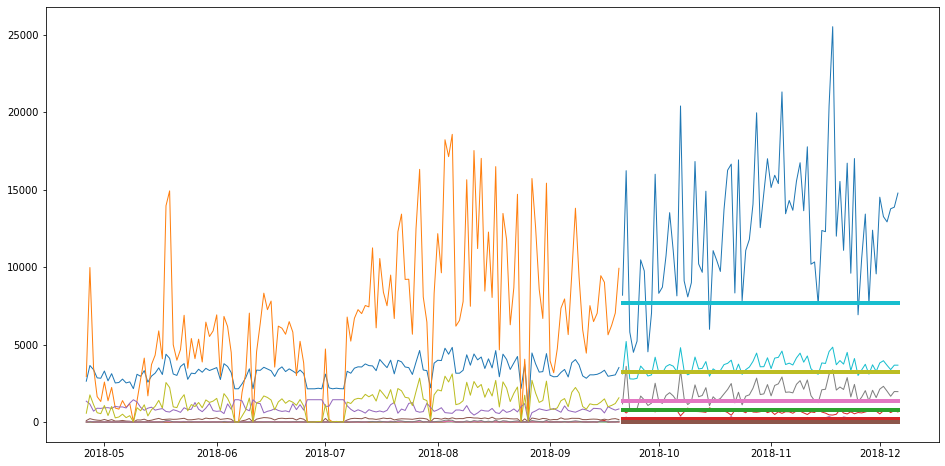

In [68]:
periods = 30
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]
plot_and_eval(target_vars, train = train, test = test)

In [69]:
eval_df = append_eval_df(model_type='moving_average', target_vars=target_vars, train = train, test = test)

calories_burned 



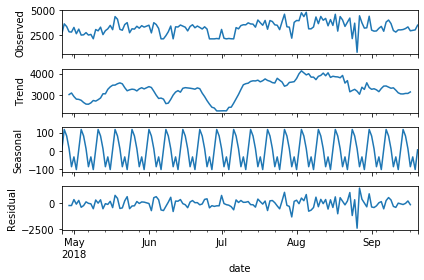

steps 



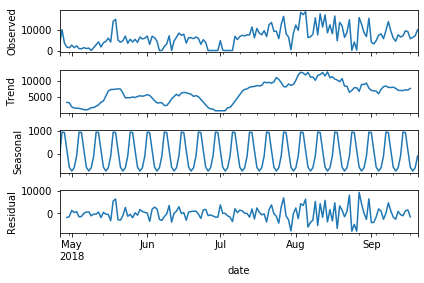

distance 



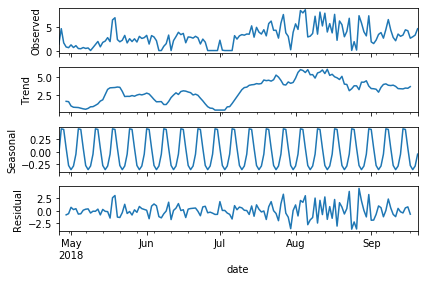

floors 



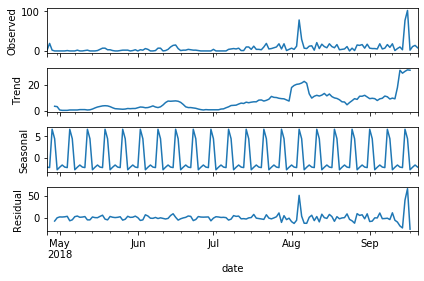

minutes_sedentary 



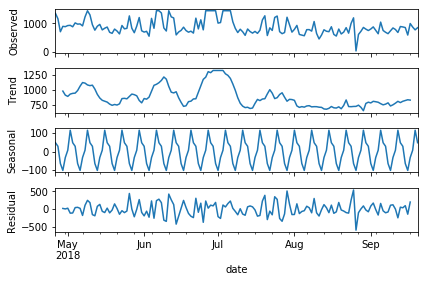

minutes_lightly_active 



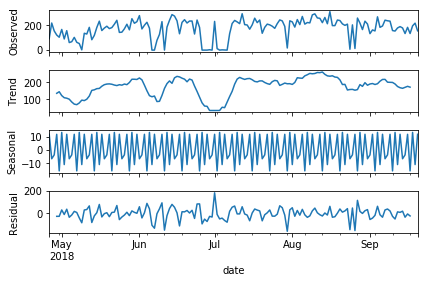

minutes_fairly_active 



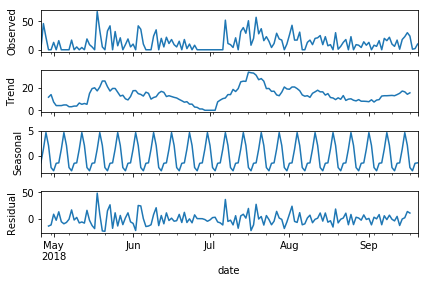

minutes_very_active 



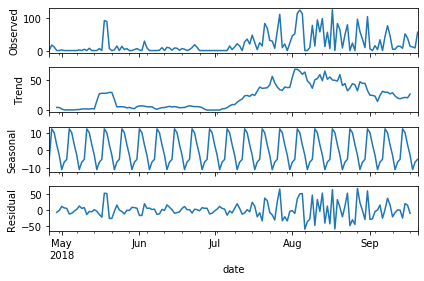

activity_calories 



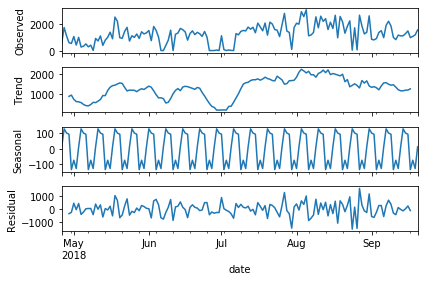

In [71]:
import statsmodels.api as sm

for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('D').mean()).plot()
    plt.show()

calories_burned -- MSE: 752042.66 RMSE: 867.20
steps -- MSE: 31151561.26 RMSE: 5581.36
distance -- MSE: 7.55 RMSE: 2.75
floors -- MSE: 1550.25 RMSE: 39.37
minutes_sedentary -- MSE: 155897.01 RMSE: 394.84
minutes_lightly_active -- MSE: 11520.67 RMSE: 107.33
minutes_fairly_active -- MSE: 532.11 RMSE: 23.07
minutes_very_active -- MSE: 1718.38 RMSE: 41.45
activity_calories -- MSE: 1191099.94 RMSE: 1091.38


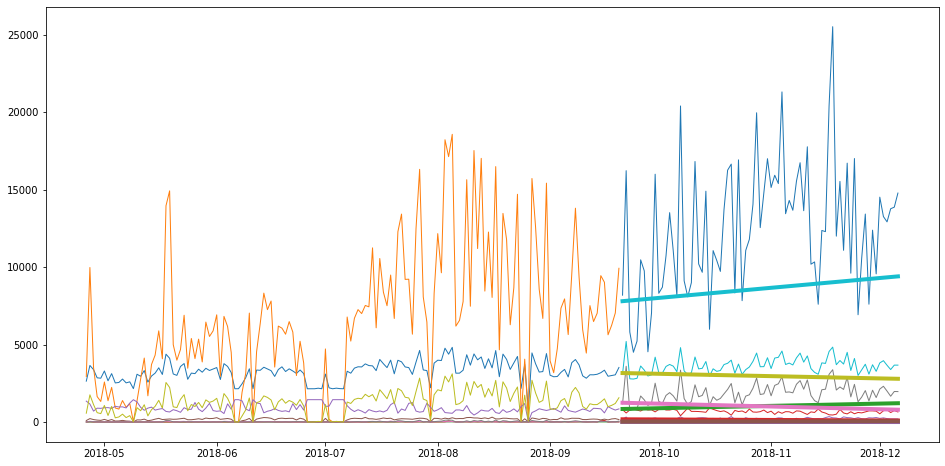

In [72]:
from statsmodels.tsa.api import Holt

for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

In [77]:
# train[target_vars].describe()

target2 = ['minutes_sedentary']

minutes_sedentary -- MSE: 276313.32 RMSE: 525.66


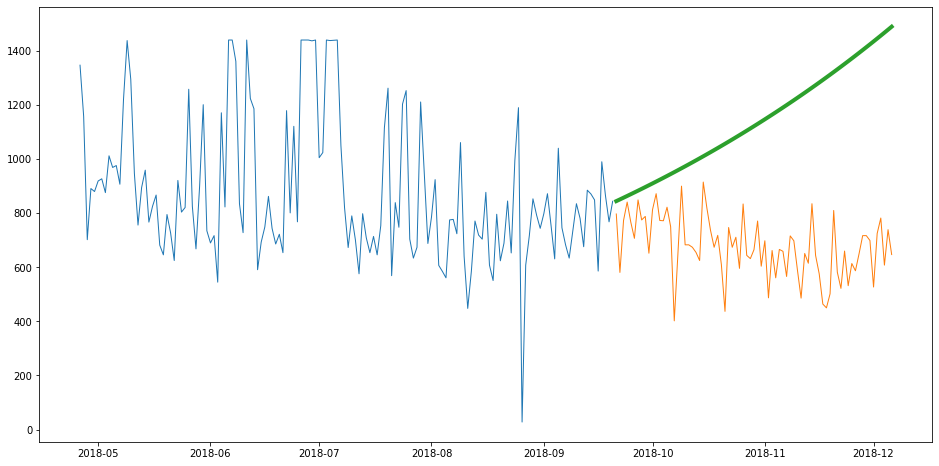

In [78]:
for var in target2:
    model = Holt(train[var], exponential=True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target2, train, test)
eval_df = append_eval_df(model_type='holts_exponential_trend', target_vars=target2, train = train, test = test)